In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/GaussianSpin`


In [2]:
using GaussianSpin
using HDF5
using KernelDensity
using LaTeXStrings
using MCMCChains
using Printf
using StatsPlots

In [18]:
var_names = [:beta, :mu_Z1, :sxy1, :sz1, :mu_Z2, :sxy2, :sz2, :rho1, :rho2, :Neff, :chieff]
trace = h5open(joinpath(@__DIR__, "..", "chains", "two_gaussian.h5"), "r") do f
    read(f, Chains)
end
trace[var_names]

Chains MCMC chain (1000×11×3 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 3
Samples per chain = 1000
parameters        = Neff, beta, chieff, mu_Z1, mu_Z2, rho1, rho2, sxy1, sxy2, sz1, sz2
internals         = 

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat 
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64 

        Neff   108.1610   48.5196     0.8858    2.0146    723.0066    1.0000
        beta     2.5334    1.1398     0.0208    0.0293   1722.2421    1.0023
      chieff     0.0722    0.0920     0.0017    0.0019   2832.8382    0.9994
       mu_Z1     0.2059    0.0747     0.0014    0.0020    908.6045    1.0000
       mu_Z2    -0.0948    0.0700     0.0013    0.0023    614.2160    1.0004
        rho1     0.1040    0.2778     0.0051    0.0062   2046.3204    1.0013
        rho2     0.0122    0.2659     0.0049    0.0066   2376.6606    1.0019
        sxy1     0.0543    0.0429     0.0008    0.

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/wfarr/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/wfarr/.julia/packages/MCMCChains/IKF6o/src/chains.jl:364


In [19]:
plot(trace[var_names])

In [20]:
scatter(vec(abs.(trace["xyz1[1]"])), vec(trace["xyz1[3]"]), xlabel=L"x", ylabel=L"z", label=L"\vec{s}_1")
scatter!(vec(abs.(trace["xyz2[1]"])), vec(trace["xyz2[3]"]), label=L"\vec{s}_2")

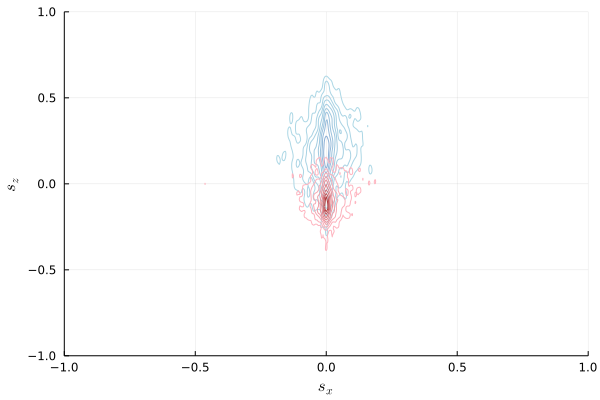

In [21]:
s1kde = kde((vec(trace["xyz1[1]"]), vec(trace["xyz1[3]"])))
s2kde = kde((vec(trace["xyz2[1]"]), vec(trace["xyz2[3]"])))
l1 = kde_credible_levels(s1kde, collect(0.1:0.1:0.9))
l2 = kde_credible_levels(s2kde, collect(0.1:0.1:0.9))
contour(s1kde.x, s1kde.y, s1kde.density', c=:blues, colorbar=false, xlabel=L"s_x", ylabel=L"s_z", label="\vec{s}_1", levels=l1)
contour!(s2kde.x, s2kde.y, s2kde.density', c=:reds, colorbar=false, label=L"\vec{s}_2", levels=l2)
xlims!(-1, 1)
ylims!(-1, 1)

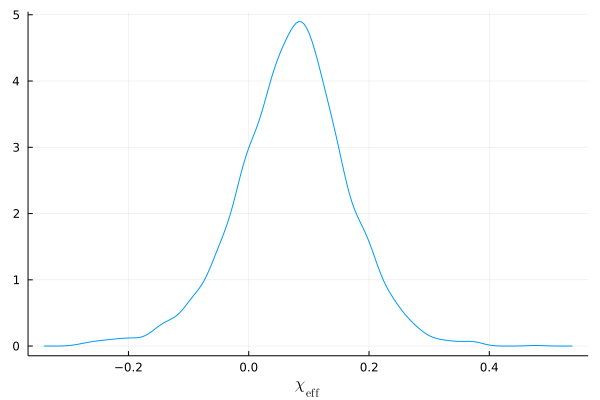

In [22]:
@df trace density(:chieff, xlabel=L"\chi_\mathrm{eff}", label=nothing)

In [23]:
println(@sprintf("P(chi_eff < 0) = %.2f", sum(trace[:chieff] .< 0)/length(trace[:chieff])))

P(chi_eff < 0) = 0.20


In [24]:
tilt1 = map(trace["xyz1[1]"], trace["xyz1[2]"], trace["xyz1[3]"]) do x,y,z
    tilt([x, y, z])
end
tilt2 = map(trace["xyz2[1]"], trace["xyz2[2]"], trace["xyz2[3]"]) do x,y,z
    tilt([x, y, z])
end;

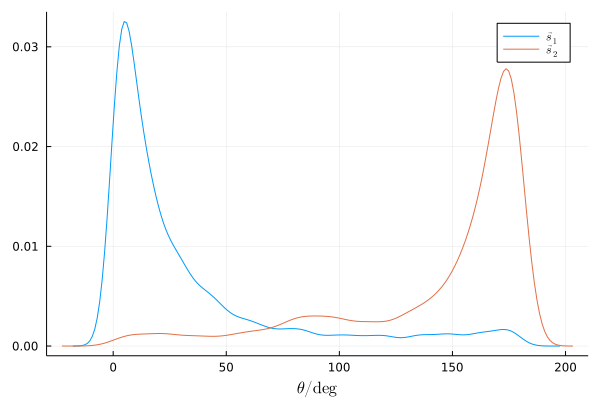

In [25]:
density(180.0/pi.*vec(tilt1), xlabel=L"\theta / \mathrm{deg}", label=L"\vec{s}_1")
density!(180.0/pi.*vec(tilt2), label=L"\vec{s}_2")

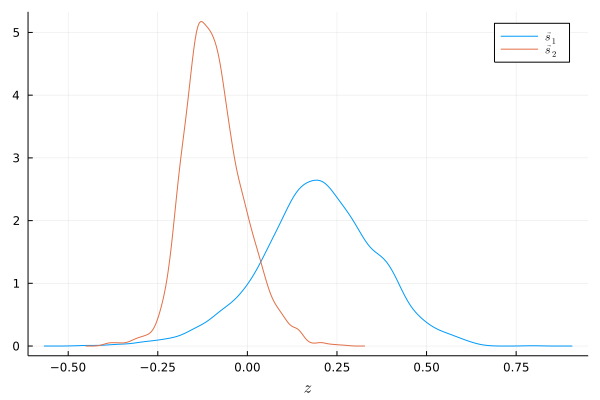

In [26]:
density(vec(trace["xyz1[3]"]), label=L"\vec{s}_1")
density!(vec(trace["xyz2[3]"]), xlabel=L"z", label=L"\vec{s}_2")

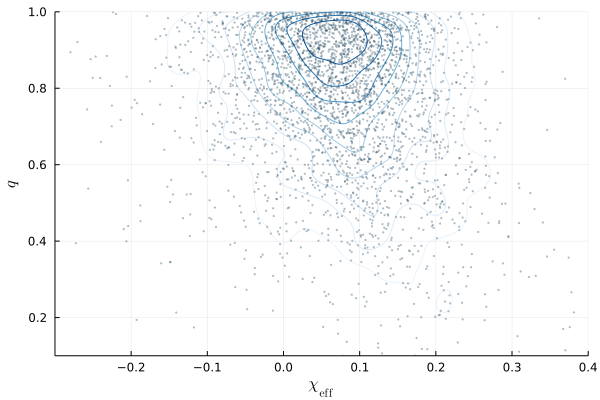

In [36]:
k = kde((vec(trace[:chieff]), vec(trace[:q])))
plot(k, c=:Blues, colorbar=nothing, xlabel=L"\chi_\mathrm{eff}", ylabel=L"q", 
     levels=kde_credible_levels(k, 0.1:0.1:0.9), xlims=(-0.3,0.4), ylims=(0.1, 1))
scatter!(vec(trace[:chieff]), vec(trace[:q]), markersize=1, legend=nothing, alpha=0.25, color=1)

Let's fit to a line, and see what slope we get.  Here we fit to 
$$
\chi_\mathrm{eff} = \chi_{\mathrm{eff},0} + \alpha \left( 1 - q\right)
$$
[Callister, et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...922L...5C/abstract) find $\chi_{\mathrm{eff},0} = 0.19^{+0.11}_{-0.09}$ and $\alpha = -0.46^{+0.29}_{-0.28}$ at 90% CI.

In [38]:
M = hcat(ones(length(vec(trace[:q]))), vec(trace[:q]) .- 0.5)
M \ vec(trace[:chieff])

2-element Vector{Float64}:
  0.10046130748787341
 -0.10448790547052052